In [33]:
import pandas as pd
import numpy as np
from scipy import sparse as sps
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [34]:
import lenskit
import lenskit.crossfold as xf
from  lenskit.crossfold import TTPair

In [35]:
from lenskit.algorithms import als, basic, item_knn, user_knn
from lenskit.algorithms.basic import Fallback
from lenskit.algorithms.als import BiasedMF, ImplicitMF
from lenskit.algorithms.implicit import BPR

In [36]:
from lenskit.batch import MultiEval
from lenskit.crossfold import partition_users, SampleN
from lenskit import batch, topn, util
from tf_idf import tf_idf

In [6]:
saved = open("pickle/game_reviews.pickle","rb")
game_reviews = pickle.load(saved)
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [7]:
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [8]:
#game_reviews['review'] = game_reviews['review'].applymap(str)
#game_reviews['review'] = game_reviews['review'].astype(str)

In [9]:
user_game = open("pickle/user_games.pickle","rb")
user_games = pickle.load(user_game)
user_games.head()

,user_id,item_id,item_name
0,76561197970982479,10,Counter-Strike
1,76561197970982479,20,Team Fortress Classic
2,76561197970982479,30,Day of Defeat
3,76561197970982479,40,Deathmatch Classic
4,76561197970982479,50,Half-Life: Opposing Force


In [10]:
#user_games[user_games['item_id']>50]

In [11]:
user_games = user_games.rename(columns={'user_id': 'user', 'item_id': 'item'})
user_games_list = user_games[['item', 'user']]
user_games_list.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [12]:
reviews = game_reviews[['item_id', 'user_id','review']]
reviews = reviews.rename(columns={'user_id': 'user', 'item_id': 'item'})
reviews.shape

(58430, 3)

In [13]:
reviews.tail()

,item,user,review
58425,70,76561198312638244,a must have classic from steam definitely wort...
58426,362890,76561198312638244,this game is a perfect remake of the original ...
58427,273110,LydiaMorley,had so much fun plaing this and collecting res...
58428,730,LydiaMorley,:D
58429,440,LydiaMorley,so much fun :D


### join user-item and reviws

In [14]:
rev_item = set(reviews['item'])
user_item = set(user_games['item'])
item_butNot_rev = user_item.intersection(rev_item) ## items that have reviews

### taking only reviwed item

In [15]:
user_item_rev = user_games_list[user_games_list['item'].isin(list(item_butNot_rev))] 
user_item_rev.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [16]:
result = pd.merge(user_item_rev, reviews, how = 'outer', on=['item', 'user'])
result.shape

(4219381, 3)


# Analysis

### so every item in result data has reviews but not every user is a reviwer

In [17]:
result.nunique()

item       3682
user      71856
review    55312
dtype: int64

In [18]:
reviews.nunique()

item       3682
user      25457
review    55312
dtype: int64

## Pruning

## removing less than 5 items holder

### item count and remove user less than (n)

In [19]:
def groupby_count(df, group, count):
    game_count = pd.DataFrame()
    game_count['count'] = df.groupby(group)[count].nunique()
    return game_count

In [20]:
def prune(df, condition):     ## returns a dataframe that meet the given condition
    user_n = df.loc[df['count'] < condition ]
    return user_n

In [21]:
game_count = groupby_count(result, 'user', 'item')
game_count.sort_values(by = 'count', ascending = False).head()

,count
user,
phrostb,2698
chidvd,2514
piepai,2419
thugnificent,2373
DeEggMeister,1914


In [22]:
user_5 = prune(game_count, 5)

In [23]:
user_less_5 = user_5.index
user_less_5

Index(['001002130882', '00284702', '010195345', '0102705195',
       '011111135489484797', '0132489', '025652', '03375616256', '0445233',
       '07824',
       ...
       'zellenal', 'zeronacho', 'zielinskak40', 'ziko21', 'zillarino',
       'zimbalor', 'zixwot', 'zombifiedddd', 'zraicis', 'zzonci'],
      dtype='object', name='user', length=9833)

In [24]:
pruned_data_5 = result.set_index('user').drop(user_less_5)
pruned_data_5.reset_index(inplace = True)
pruned_data_5.head()

,user,item,review
0,76561197970982479,10,NaN
1,76561197970982479,20,NaN
2,76561197970982479,30,NaN
3,76561197970982479,40,NaN
4,76561197970982479,50,NaN


## Pruning Analysis

#### 13% of users are missed

In [24]:
#len(prune(game_count, 2))  ## users that have 1 items in library
pruned_user_len = len(prune(game_count, 5))/result['user'].nunique()
pruned_user_len

0.13684313070585616

#### .5% items are missed

In [25]:
reviews.nunique()

item       3682
user      25457
review    55312
dtype: int64

In [26]:
pruned_data_5.nunique()

user      62023
item       3663
review    51269
dtype: int64

In [27]:
pruned_item = result['item'].nunique()-pruned_data_5['item'].nunique()
pruned_item_frac = pruned_item/result['item'].nunique()
pruned_item_frac

0.005160239000543183

#### 7% reviews are missed

In [28]:
pruned_rev = result['review'].nunique()-pruned_data_5['review'].nunique()
pruned_rev_frac = pruned_rev/result['review'].nunique()
pruned_rev_frac

0.07309444605148974

## check user item

In [29]:
pruned_data_5.loc[pruned_data_5['user'] == 'kenkaniff']

,user,item,review
4196366,kenkaniff,42680,This is honestly the worst Call of Duty ever. ...
4196367,kenkaniff,242050,Great game! Recommend it!
4196368,kenkaniff,209160,Not that great of a game actually! The multipl...
4196369,kenkaniff,8190,This is one of my favourite games! It is reall...
4196370,kenkaniff,24240,"Love it, can't stop playing it!!"


In [30]:
only_rev = pruned_data_5.dropna()

In [31]:
item_data1 = pd.DataFrame({'review': only_rev.groupby(['item']).review.apply(lambda x:' '.join(x))})
item_data1.reset_index(inplace=True)

## Partition by user

In [30]:
file = open("pairs_user_new.pickle","rb")
pairs_user = pickle.load(file)

In [31]:
truth = pd.concat((p.test for p in pairs_user))

In [24]:
truth.shape

(62023, 3)

In [28]:
truth[truth['user']=='-2SV-vuLB-Kg']

,user,item,review
3197437,-2SV-vuLB-Kg,4720,NaN


## Evaluation

In [36]:
def algo_eval(path, algo, dataset):
    evaluation = batch.MultiEval(path=path, predict=False, recommend=True)
    evaluation.add_algorithms(algos=algo)
    evaluation.add_datasets(data=dataset)
    evaluation.run()

In [37]:
def ndcg(file_name, truth):
    recs = pd.read_parquet(file_name)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    ndcg = rla.compute(recs, truth)
    return ndcg

In [17]:
def RR(rec, truth):
    #recs = pd.read_parquet(file_name)
    #recs = rec
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.recip_rank)
    RR_result = rla.compute(rec, truth)
    return RR_result

In [15]:
def recall(recs, truth):
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.recall)
    RR_result = rla.compute(recs, truth)
    return RR_result

In [ ]:
from fastparquet import ParquetFile
result_test = pd.DataFrame()
#df.to_parquet(tmp_file, engine='pyarrow', compression='gzip')
pf = ParquetFile('results/steam/pruned_5_new/recommendations.parquet')
for df in pf.iter_row_groups():
    a = df.loc[df['rank']<101]
    result_test = result_test.append(a,sort = False)
    #print(a.head(n=10))

In [16]:
result_test.to_parquet('results/steam/pruned_5_new/recs1000.parquet')
result_test.to_csv("results/steam/pruned_5_new/recs1000.csv")

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


### 100 rank

In [17]:
result100 = pd.read_parquet('results/steam/pruned_5_new/recs100.parquet')

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [18]:
def merge_algoname(rec_algo):
    legend = pd.read_csv("results/steam/pruned_5_new/runs.csv")
    legend = legend.set_index('RunId').loc[:,'AlgoStr']
    merged = rec_algo.join(legend, on='RunId')
    return merged

In [22]:
def result_By_algo(df, metric):
    df.reset_index(inplace = True)
    df_mean = pd.DataFrame(df.groupby(['AlgoStr'])[metric].mean())
    df_mean.reset_index(inplace = True)
    return df_mean

## MRR

In [27]:
RR_algo_comp = RR(result100, truth)
RR_algo_comp.to_parquet('results/steam/pruned_5_new/RR100.parquet')
RR_algo_comp.to_csv("results/steam/pruned_5_new/RR100.csv")

/home/amifaraj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [30]:
RR_algo = merge_algoname(RR_algo_comp)
RR_algo.to_parquet('results/steam/pruned_5_new/RR_algo100.parquet')
RR_algo.to_csv("results/steam/pruned_5_new/RR_algo100.csv")
RR_algo.head()

recip_rank                                            AlgoStr
user    RunId                                                               
--000-- 11       0.000000                                             Tf-IDF
        12       0.031250                     ItemItem(nnbrs=20, msize=None)
        13       0.029412                                            Popular
        14       0.071429         als.ImplicitMF(features=40, reg=0.1, w=40)
        15       0.015873  Implicit(<implicit.bpr.BayesianPersonalizedRan...

In [24]:
MRR_by_algo = result_By_algo(RR_algo, 'recip_rank')
MRR_by_algo

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,AlgoStr,recip_rank
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.145532
1,"ItemItem(nnbrs=20, msize=None)",0.151171
2,Popular,0.093430
3,Tf-IDF,0.052362
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.107147


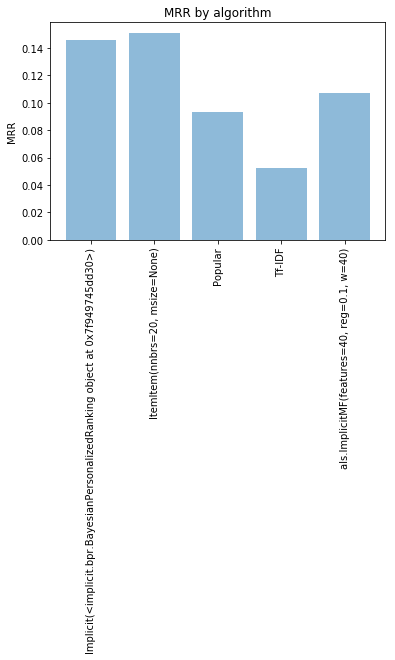

In [35]:
X = MRR_by_algo['AlgoStr']
Y = MRR_by_algo['recip_rank']


plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('MRR')
plt.title('MRR by algorithm')

plt.show()

## Recall

In [37]:
recall_user = recall(result100, truth)

In [38]:
recall_user100 = merge_algoname(recall_user)
recall_by_algo1000 = result_By_algo(recall_user100, 'recall')
recall_by_algo1000

,AlgoStr,recall
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.560679
1,"ItemItem(nnbrs=20, msize=None)",0.580930
2,Popular,0.486965
3,Tf-IDF,0.385099
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.677120


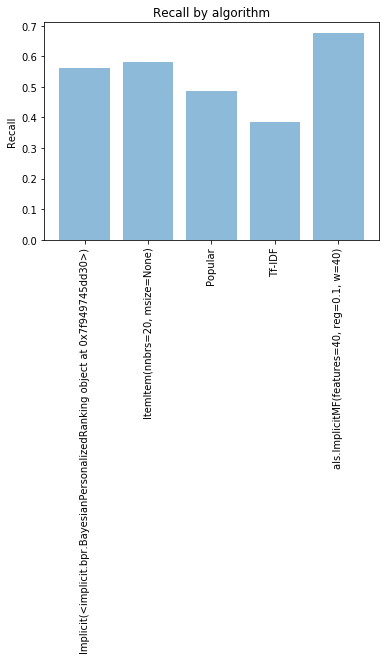

In [40]:
X = recall_by_algo1000['AlgoStr']
Y = recall_by_algo1000['recall']


plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('Recall')
plt.title('Recall by algorithm')

plt.show()

## Rank 1000

In [7]:
RR_algo_comp1000 = pd.read_parquet('results/steam/pruned_5_new/RR_algo1000.parquet')
RR_algo_comp1000.shape

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(310115, 1)

In [26]:
RR_algo1000 = merge_algoname(RR_algo_comp1000)
MRR_by_algo1000 = result_By_algo(RR_algo1000, 'recip_rank')
MRR_by_algo1000

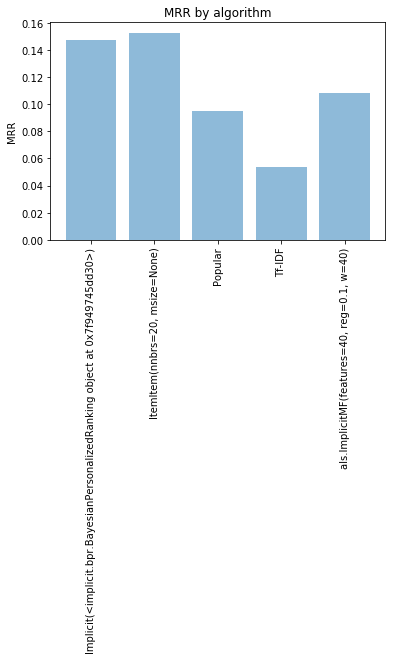

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = MRR_by_algo1000['AlgoStr']
Y = MRR_by_algo1000['recip_rank']


plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('MRR')
plt.title('MRR by algorithm')

plt.show()